In [1]:
from tqdm import tqdm
import os
import glob
import pybedtools as pbt
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from ipyparallel import Client
from scipy.stats import binom_test
from scipy.stats import norm

DVIEW = Client()[:]
DVIEW.block=True
len(DVIEW)

30

### Split Remap bed file by TF and then for each TF by chromosome

In [3]:
out_handles = {}
os.system('rm -rf ../data/REMAP_TFBS/tf_wise_files')
os.system('mkdir ../data/REMAP_TFBS/tf_wise_files')

with open('../data/REMAP_TFBS/nrPeaks_all.bed') as handle:
    for line in tqdm(handle):
        cols = line.split('\t')
        tf_name = cols[3]
        if tf_name not in out_handles:
            out_name = '../data/REMAP_TFBS/tf_wise_files/' + tf_name + '.bed'
            out_handles[tf_name] = open(out_name, 'w')
        pos = int(cols[6])
        start = pos - 25
        stop = pos + 25
        out_line = "\t".join([cols[0], str(start), str(stop)])
        out_handles[tf_name].write(out_line+'\n')

for each_tf in out_handles:
    out_handles[each_tf].close()

8773705it [01:05, 134973.35it/s]


In [5]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']

for tf_name in tqdm(out_handles):
    out_dir = "../data/REMAP_TFBS/tf_wise_files/%s" % tf_name
    os.system('rm -rf %s' % out_dir)
    os.system('mkdir %s' % out_dir)
    in_file = '../data/REMAP_TFBS/tf_wise_files/' + tf_name + '.bed'
    chrom_out_handles = {x: open("%s/%s.bed" % (out_dir, x), 'w') for x in chroms}
    with open(in_file) as handle:
        for line in handle:
            chrom = line.split('\t')[0]
            if chrom == 'chrM':
                continue
            chrom_out_handles[chrom].write(line)
    for chrom in chrom_out_handles:
        chrom_out_handles[chrom].close()
        
for tf_name in tqdm(out_handles):
    in_file = '../data/REMAP_TFBS/tf_wise_files/' + tf_name + '.bed'
    os.system("rm %s" % in_file)

100%|██████████| 237/237 [00:04<00:00, 56.94it/s]


### Calculate Expectation score within each peak for each TF

In [62]:
def get_scores_in_peaks(chrom):
    
    import numpy as np
    import glob

    def bed_to_intervals(fn):
        intervals = []
        with open(fn) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                intervals.append((int(c[1]), int(c[2])))
        return intervals
#         if len(intervals) > 50:
#             return [intervals[np.random.randint(len(intervals))]
#                     for x in range(50)]
#         else:
#             return intervals

    in_dir = '/home/parashar/scratch/quadcomb/data/sniprq_scores'
    snipr = {
        'positive': np.load('%s/%s_positive.npy' % (in_dir, chrom)),
        'negative': np.load('%s/%s_negative.npy' % (in_dir, chrom))
    }
    
    base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
    tfs = [x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))]
    res = []
    cutoff = 25
    for tf in tfs:
        intervals = bed_to_intervals("%s/%s/%s.bed" % (base_dir, tf, chrom))
        if len(intervals) > 0:
            s_p = [1 if any(snipr['positive'][i[0]:i[1]] > cutoff) is True
                   else 0 for i in intervals]
            s_n = [1 if any(snipr['negative'][i[0]:i[1]] > cutoff) is True
                   else 0 for i in intervals]
            score = np.array(s_p) + np.array(s_n)
            a = len(np.where(score > 0)[0])
            
#             adj_p = [1 if any(snipr['positive'][i[0]-550:i[0]-500] > cutoff) is True
#                      else 0 for i in intervals]
            
#             adj_n = [1 if any(snipr['negative'][i[0]-550:i[0]-500] > cutoff) is True
#                      else 0 for i in intervals]
#             adj_score = np.array(adj_p) + np.array(adj_n)
#             b = len(np.where(adj_score > 0)[0])
            
            #res.append([a, len(score)-a, b, len(score)-b])
            res.append([a, len(score)-a])
        else:
            #res.append([0, 0, 0, 0])
            res.append([0, 0])
    return res

In [110]:
def get_scores_in_peaks(chrom):
    
    import numpy as np
    import glob

    def bed_to_intervals(fn):
        intervals = []
        with open(fn) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                intervals.append((int(c[1]), int(c[2])))
        return intervals

    in_dir = '/home/parashar/scratch/quadcomb/data/sniprq_scores'
    pos = np.load('%s/%s_positive.npy' % (in_dir, chrom))
    neg = np.load('%s/%s_negative.npy' % (in_dir, chrom))
    
    base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
    tfs = [x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))]
    res = []
    for tf in tfs:
        intervals = bed_to_intervals("%s/%s/%s.bed" % (base_dir, tf, chrom))
        if len(intervals) > 0:
            s_p = [np.mean(pos[i[0]:i[1]]) for i in intervals]
            s_n = [np.mean(neg[i[0]:i[1]]) for i in intervals]
            score = np.array(s_p) + np.array(s_n)            
            res.append(list(score))
        else:
            res.append([])
    return res

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
tfs = np.array([x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))])
rep_res = DVIEW.map_sync(get_scores_in_peaks, chroms)
chrom_aggregated = [[] for x in range(len(tfs))]
for i in rep_res:
    for j in range(len(tfs)):
        chrom_aggregated[j].extend(i[j])

180 240
120 180
60 120
0 60


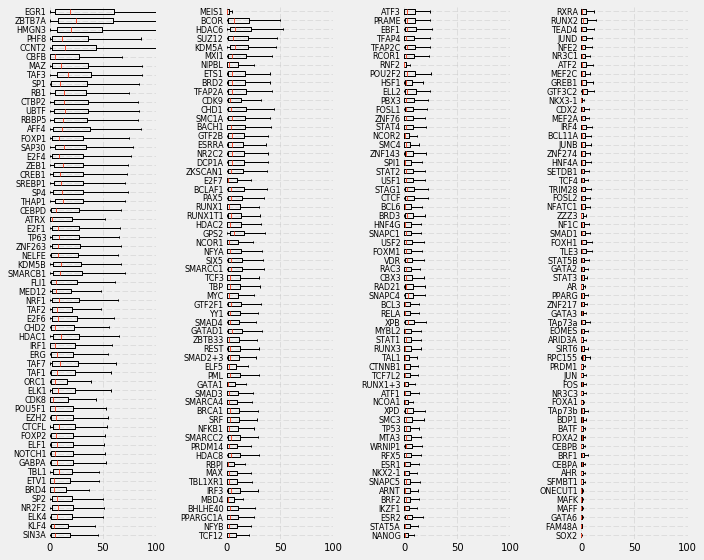

In [222]:
agg_means = np.array([np.mean(chrom_aggregated[x]) for x in range(len(tfs))])
idx = np.argsort(agg_means)

fig, axis = plt.subplots(1, 4, figsize=(10, 8))

start, end = (180, len(idx)+1)
for ax in axis:
    print (start, end)
    ax.boxplot([chrom_aggregated[x] for x in idx[start:end]], sym='', vert=False)
    ax.set_yticklabels(tfs[idx[start:end]], fontsize=8)
    start -= 60
    end -= 60
    ax.set_xlim((0, 100))
    ax.xaxis.set_tick_params(labelsize=10)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
        ax.grid(which='major', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../images/tfbs_mean_scores_dist.svg', transparent=True, edgecolor='none')
plt.show()

In [200]:
def get_scores_in_peaks(chrom):
    
    import numpy as np
    import glob

    def bed_to_intervals(fn):
        intervals = []
        with open(fn) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                intervals.append((int(c[1]), int(c[2])))
        return intervals

    in_dir = '/home/parashar/scratch/quadcomb/data/sniprq_scores'
    pos = np.load('%s/%s_positive.npy' % (in_dir, chrom))
    neg = np.load('%s/%s_negative.npy' % (in_dir, chrom))
    
    base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
    tfs = [x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))]
    res = []
    for tf in tfs:
        intervals = bed_to_intervals("%s/%s/%s.bed" % (base_dir, tf, chrom))
        if len(intervals) > 0:
            sp = [1 if len(np.where(pos[i[0]:i[1]] > 25)[0]) > 0 else 0 for i in intervals]
            sn = [1 if len(np.where(neg[i[0]:i[1]] > 25)[0]) > 0 else 0 for i in intervals]
            res.append((sum(sp) + sum(sn))/(2*len(intervals)))
        else:
            res.append(0)
    return res

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
tfs = np.array([x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))])
rep_res = DVIEW.map_sync(get_scores_in_peaks, chroms)
chrom_aggregated_count = [0 for x in range(len(tfs))]
for i in rep_res:
    for j in range(len(tfs)):
        chrom_aggregated_count[j]+=i[j]
chrom_aggregated_count = np.array(chrom_aggregated_count)/24

180 240
120 180
60 120
0 60


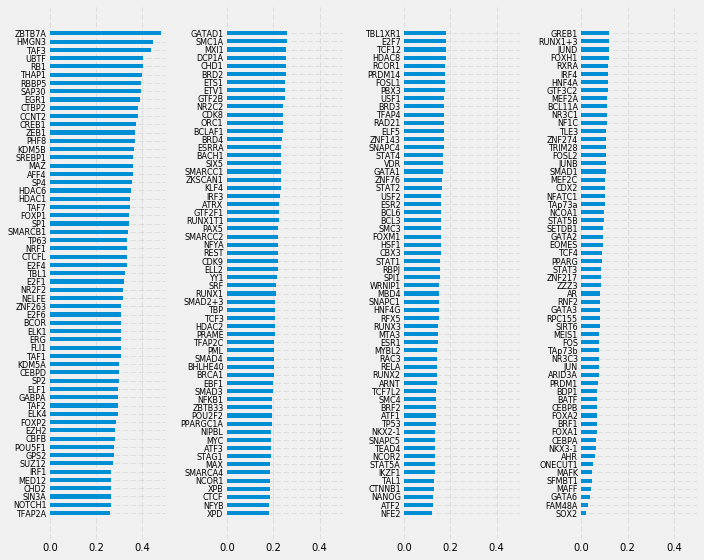

In [224]:
idx = np.argsort(chrom_aggregated_count)

fig, axis = plt.subplots(1, 4, figsize=(10, 8))

start, end = (180, len(idx)+1)
for ax in axis:
    print (start, end)
    ax.barh(range(len(idx[start:end])), chrom_aggregated_count[idx[start:end]], height=0.5)
    ax.set_yticks(range(len(idx[start:end])))
    ax.set_yticklabels(tfs[idx[start:end]], fontsize=8)
    start -= 60
    end -= 60
    ax.set_xlim((0, 0.5))
    ax.xaxis.set_tick_params(labelsize=10)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
        ax.grid(which='major', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('../images/tfbs_coverage_above25.svg', transparent=True, edgecolor='none')
plt.show()

In [ ]:
agg_means = np.array([np.mean(chrom_aggregated[x]) for x in range(len(tfs))])
idx = np.argsort(agg_means)

fig, axis = plt.subplots(1, 2, figsize=(8, 18))

axis[0].boxplot([chrom_aggregated[x] for x in idx[120:]], sym='', vert=False)
axis[0].set_yticklabels(tfs[idx[120:]], fontsize=8)
axis[1].boxplot([chrom_aggregated[x] for x in idx[:120]], sym='', vert=False)
axis[1].set_yticklabels(tfs[idx[:120]], fontsize=8)
for ax in axis:
    #ax.set_xlim((0, 150))
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
        ax.grid(which='major', linestyle='--', alpha=0.5)
plt.show()

In [139]:
def get_scores_in_random_peaks(chrom):
    
    import numpy as np

    in_dir = '/home/parashar/scratch/quadcomb/data/sniprq_scores'
    pos = np.load('%s/%s_positive.npy' % (in_dir, chrom))
    neg = np.load('%s/%s_negative.npy' % (in_dir, chrom))
    rand_nums = [25+np.random.randint(len(pos)-25) for x in range(1000)]
    intervals = [(x-25, x+25) for x in rand_nums]
    s_p = [np.mean(pos[i[0]:i[1]]) for i in intervals]
    s_n = [np.mean(neg[i[0]:i[1]]) for i in intervals]
    scores = np.array(s_p) + np.array(s_n)            
    return scores

chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
rep_res = DVIEW.map_sync(get_scores_in_random_peaks, chroms)

random_aggregated = []
for i in rep_res:
    random_aggregated.extend(i)

In [141]:
random_aggregated = []
for i in rep_res:
    random_aggregated.extend(i)

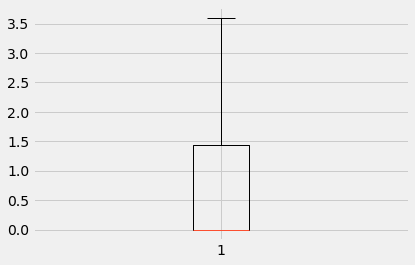

In [147]:
plt.boxplot([random_aggregated], sym='')
plt.show()

In [119]:
agg_means = np.array([np.mean(chrom_aggregated[x]) for x in range(len(tfs))])
idx = np.argsort(agg_means)

In [120]:
for i,j in zip(agg_means[idx], tfs[idx]):
    print (j, i)

SOX2 1.03558361079
FAM48A 1.32647908001
GATA6 1.56407237315
MAFF 1.64095165265
MAFK 1.92504905633
ONECUT1 1.99202746318
SFMBT1 2.18015060241
AHR 2.74454279318
CEBPA 2.79247952017
BRF1 2.88048109966
CEBPB 3.10268848803
FOXA2 3.16304955341
BATF 3.28677195472
BDP1 3.34978508217
TAp73b 3.45954383216
FOXA1 3.56100342093
NR3C3 3.89434046104
FOS 3.93164052223
JUN 3.93441679467
PRDM1 3.95793178837
RPC155 4.00726559715
SIRT6 4.14275862069
ARID3A 4.33142304686
EOMES 4.5071629069
TAp73a 4.55537774984
GATA3 4.57203951914
ZNF217 4.58634289439
PPARG 4.72725508906
AR 4.75728693551
STAT3 4.88115692996
GATA2 5.07597789657
STAT5B 5.29482385237
TLE3 5.5632132964
FOXH1 5.64576374246
SMAD1 5.67329961868
NF1C 5.72063787068
ZZZ3 5.8476056338
NFATC1 5.85603653147
FOSL2 5.87041667625
TRIM28 5.93289356725
TCF4 6.00999608825
SETDB1 6.11871570742
HNF4A 6.16704102732
ZNF274 6.18177610334
JUNB 6.18320869708
BCL11A 6.18873508824
IRF4 6.366652748
MEF2A 6.47460821066
CDX2 6.62524487532
NKX3-1 6.62551569853
GTF3C2 6.64

In [87]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
tfs = np.array([x.split('/')[-1] for x in sorted(glob.glob("%s/*" % base_dir))])

In [74]:
#rep_res = []
#for i in tqdm(range(0)):
    #rep_res.append(np.array(DVIEW.map_sync(get_scores_in_peaks, chroms)).sum(axis=0))
rep_res = np.array(DVIEW.map_sync(get_scores_in_peaks, chroms)).sum(axis=0)

In [76]:
fc = rep_res[:, 0]/(rep_res[:, 0] + rep_res[:, 1])

In [80]:
idx = np.argsort(fc)[::-1]

In [85]:
n = 1
for i,j in zip(tfs[idx], fc[idx]):
    print (n, i,j)
    n+=1

1 ZBTB7A 0.795593342115
2 TAF3 0.766167498613
3 HMGN3 0.761963096241
4 EGR1 0.70546254919
5 SAP30 0.69639242767
6 UBTF 0.689120693455
7 RB1 0.688405797101
8 THAP1 0.684347074085
9 CTBP2 0.67982254857
10 RBBP5 0.668523821921
11 ZEB1 0.664031620553
12 SREBP1 0.655145326002
13 AFF4 0.649122807018
14 KDM5B 0.647272446299
15 SP4 0.643497757848
16 PHF8 0.634093932262
17 CCNT2 0.633713210887
18 HDAC1 0.629836381136
19 CREB1 0.624138149156
20 SMARCB1 0.614260459635
21 MAZ 0.611141477635
22 NRF1 0.605112552461
23 TAF7 0.603626943005
24 TBL1 0.592698370528
25 SP1 0.579297064043
26 FOXP1 0.578753869969
27 ZNF263 0.578361435365
28 CTCFL 0.577733460505
29 TP63 0.575334228775
30 HDAC6 0.574774774775
31 KDM5A 0.574683544304
32 E2F4 0.573682613533
33 E2F1 0.561890979257
34 NR2F2 0.559911754258
35 ELK1 0.55765819042
36 NELFE 0.556818181818
37 E2F6 0.546902701701
38 TAF2 0.536535677907
39 SP2 0.535195736078
40 ELK4 0.526279863481
41 CEBPD 0.526098780595
42 TAF1 0.52585651247
43 ERG 0.525783166803
44 BCO

In [57]:
pvals = []
coverages = []
enrichments = []
for res in tqdm(rep_res):
    tp, p, c, e = 0, [], [], []
    for i in range(len(tfs)):
        t = list(res[i].reshape(2 ,2))
        if np.array(t).sum() > 0:
            t_peaks = res[i][0]+res[i][1]
            p.append(binom_test(res[i][0]//10, t_peaks//10,
                       p=res[i][2]/(res[i][2]+res[i][3]), alternative='greater'))
            c.append(res[i][0]/(t_peaks))
            e.append(res[i][0]/res[i][2])
            tp += t_peaks
    pvals.append(np.array(p))
    coverages.append(np.array(c))
    enrichments.append(np.array(e))
pvals = np.array(pvals)
coverages = np.array(coverages)
enrichments = np.array(enrichments)

pvals = np.median(pvals, axis=0)
idx = np.argsort(pvals)[::-1]
log_pvals = np.array([-1*(np.log10((x+1e-323))) for x in pvals])
coverages = np.median(coverages, axis=0)
enrichments = np.median(enrichments, axis=0)

100%|██████████| 2/2 [00:00<00:00, 14.85it/s]


In [58]:
alpha = 0.01*(1/len(tfs))
#enrichment_cutoff = norm(enrichments.mean(), enrichments.std()).ppf(0.95)
enrichment_cutoff = 1.5
alpha, enrichment_cutoff

(4.1841004184100415e-05, 1.5)

In [59]:
select_idx = (pvals < alpha) & (enrichments > 1.5)
tfs[select_idx]

array(['BRD4', 'CCNT2', 'CTBP2', 'CTCFL', 'E2F1', 'E2F4', 'E2F6', 'EGR1',
       'ERG', 'FLI1', 'FOXP1', 'GPS2', 'HDAC1', 'HMGN3', 'MAZ', 'MED12',
       'NR2F2', 'ORC1', 'PHF8', 'RBBP5', 'SAP30', 'SMARCB1', 'SNAPC4',
       'SP1', 'SP4', 'SREBP1', 'TAF3', 'TAF7', 'TBL1', 'THAP1', 'TP63',
       'UBTF', 'ZBTB7A', 'ZEB1', 'ZNF263'], 
      dtype='<U8')

BRD4 1.79514533086 0.43375 3.47345504963e-06
CCNT2 1.64981104319 0.636956521739 1.20111489441e-07
CTBP2 1.69704750587 0.679565217391 3.1071335426e-09
CTCFL 1.54403165642 0.597826086957 9.44228577665e-06
E2F1 1.55188776448 0.5475 3.36352421389e-05
E2F4 1.5782461722 0.578380706288 5.80485131417e-06
E2F6 1.53421022551 0.547916666667 3.59410064637e-05
EGR1 1.81547619048 0.690434782609 1.45557618824e-10
ERG 1.85961262554 0.5175 5.25031900062e-08
FLI1 1.8549689441 0.51125 9.53664103857e-08
FOXP1 1.70199997715 0.59341117598 3.0623687929e-07
GPS2 2.80122066943 0.5025 1.5977031489e-15
HDAC1 1.53909109371 0.63 2.67642260739e-06
HMGN3 1.80242469919 0.753043478261 2.03050564578e-12
MAZ 1.70569377821 0.60990443093 2.10613521762e-07
MED12 2.10584428087 0.468696397942 3.57901045537e-08
NR2F2 1.63653266914 0.566666666667 2.00476852945e-06
ORC1 1.70666962437 0.436960276339 2.43990757742e-05
PHF8 1.59528684366 0.625416666667 4.19974809488e-06
RBBP5 1.61923592554 0.660467128028 4.27433928208e-08
SAP30 1.

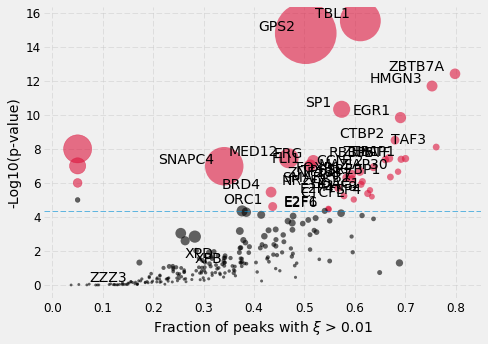

In [61]:
plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

colors = np.array(['crimson' if select_idx[x] == True else 'k' for x in range(len(tfs))])
ax.axhline(-1*np.log10(alpha), lw=1, ls='--', alpha=0.6)
ax.scatter(coverages, log_pvals, s=8+enrichments**8,
           c=colors, alpha=0.6, lw=0, label='Enrichment')

draw_circ = [8+(x**8) for x in [1.4, 1.7, 2, 2.3]]
ax.scatter([0.05 for x in range(len(draw_circ))], [5+x for x in range(len(draw_circ))],
           s=draw_circ, alpha=0.6, c=['k', 'crimson', 'crimson', 'crimson', 'crimson'])

for i in range(len(tfs)):
    if select_idx[i] == True or tfs[i] in ['ZZZ3', 'XPB', 'XPD']:
        print (tfs[i], enrichments[i], coverages[i], pvals[i])
        ax.text(coverages[i]-0.02, log_pvals[i], tfs[i],
                ha='right', va='bottom')
ax.set_xlabel('Fraction of peaks with ' + r'$\xi$'+ ' > 0.01', fontsize=14)
ax.set_ylabel('-Log10(p-value)', fontsize=14)
#ax.set_ylim((-1, 10))

clean_axis(ax)
plt.tight_layout()
plt.savefig('../images/tfbs_exp.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/tfbs_exp.svg', transparent=True, edgecolor='none')
plt.show()

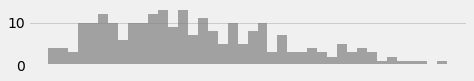

In [440]:
fig, ax= plt.subplots(1, 1, figsize=(7, 1))

ax.hist(coverages, bins=40, color='grey', alpha=0.7)
ax.set_xticks([])
plt.savefig('../images/tfbs_exp_coverages_hist.svg', transparent=True, edgecolor='none')
plt.show()

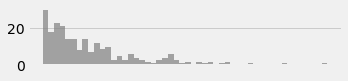

In [441]:
fig, ax= plt.subplots(1, 1, figsize=(5, 1))

ax.hist(log_pvals, bins=50, color='grey', alpha=0.7)
ax.set_xticks([])
plt.savefig('../images/tfbs_exp_pvals_hist.svg', transparent=True, edgecolor='none')
plt.show()

In [361]:
mean_scores = []
for tf in list(tfs[select_idx]):
    scores = []
    base_dir = "/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files"
    exp_dir = '/home/parashar/scratch/quadcomb/data/QG_expectation_scores_corrected_values'
    for chrom in tqdm(chroms, desc=tf):
        intervals = []
        with open("%s/%s/%s.bed" % (base_dir, tf, chrom)) as h:
            for l in h:
                c = l.rstrip('\n').split('\t')
                i = (int(c[1])-975, int(c[2])+975)
                if i[1] - i[0] == 2000:
                    intervals.append(i)
        if len(intervals) > 0:
            pos_exp = np.load('%s/%s_positive.npy' % (exp_dir, chrom), mmap_mode='r')
            neg_exp = np.load('%s/%s_negative.npy' % (exp_dir, chrom), mmap_mode='r')
            for i in intervals:
                s = pos_exp[i[0]:i[1]] + neg_exp[i[0]:i[1]]
                if len(s) == 2000:
                    scores.append(s)
    mean_scores.append(np.array(scores).mean(axis=0))

FOXH1: 100%|██████████| 24/24 [00:14<00:00,  1.66it/s]


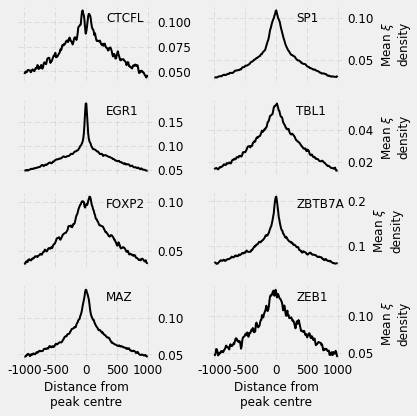

In [368]:
fig, axis = plt.subplots(4, 2, figsize=(6, 6))
row = 0
col = 0
for i,s in zip(range(len(mean_scores)), mean_scores):
    ax = axis[row, col]
    ax.plot([sum(s[x:x+10]) for x in range(0, 2010, 10)][:-1], lw=2, c='k')
    ax.text(0.65, 0.8, tfs[select_idx][i], fontsize=12, transform=ax.transAxes)
    
    ax.set_xticks([0, 50, 100, 150, 200])
    if i in  [3, 7]:
        ax.set_xticklabels([-1000, -500, 0, 500, 1000])
        ax.set_xlabel('Distance from\npeak centre', fontsize=12)
    else:
        ax.set_xticklabels([])
        
    if col == 1:
        ax.set_ylabel('Mean ' + r'$\xi$' + '\ndensity', fontsize=12)
    else:
        pass
    
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    clean_axis(ax)
    
    row += 1
    if row == 4:
        row = 0
        col = 1

plt.tight_layout()
plt.savefig('../images/select_tfbs_density.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/select_tfbs_density.svg', transparent=True, edgecolor='none')
plt.show()

In [524]:
def get_g4s_in_peaks(chrom):
    
    import pybedtools as pbt
    import numpy as np
    
    def make_control_bed(bed):
        c_bed = []
        for i in bed:
            c = str(i).rstrip('\n').split('\t')
            c_bed.append('\t'.join([c[0], str(int(c[1])-350), str(int(c[1])-300)]))
        return pbt.BedTool('\n'.join(c_bed), from_string=True)
    
    def randomize_bed(bed):
        l = bed.count()
        r_bed = []
        if l > 50:
            r_bed = [str(bed[np.random.randint(l)]) for x in range(50)]
            return pbt.BedTool('\n'.join(r_bed), from_string=True)
        else:
            return bed

    res = []
    select_tfs = ['CTCFL', 'EGR1', 'FOXP2', 'MAZ', 'SP1', 'TBL1', 'ZBTB7A', 'ZEB1']    
    tf_dir = '/home/parashar/scratch/quadcomb/data/REMAP_TFBS/tf_wise_files'
    g4_dir = '/home/parashar/scratch/quadruplexes/hg19'
    g4_bed = pbt.BedTool("%s/g3_50_3_%s_nov.bed" % (g4_dir, chrom))
    
    for tf in select_tfs:
        tf_bed = pbt.BedTool("%s/%s/%s.bed" % (tf_dir, tf, chrom))
        tot = tf_bed.count()
        if tot > 0:
            tf_bed = randomize_bed(tf_bed)
            intersect = tf_bed.intersect(g4_bed, u=True)
            control_intersect = make_control_bed(tf_bed).intersect(g4_bed, u=True)
            a = intersect.count()
            b = control_intersect.count()
            tot = tf_bed.count()
            res.append([a, tot-a, b, tot-b])
        else:
            res.append([0, 0, 0, 0])
    return res

In [523]:
g4_15_0_rep_res = []
for i in tqdm(range(100)):
    g4_15_0_rep_res.append(np.array(DVIEW.map_sync(get_g4s_in_peaks, chroms)).sum(axis=0))
g4_15_0_rep_res = np.array(g4_15_0_rep_res)

100%|██████████| 100/100 [2:28:30<00:00, 89.35s/it] 


In [528]:
x = g4_15_0_rep_res.mean(axis=0)

In [529]:
for i in g4_15_0_rep_res[1]:
    print (i)
    t_peaks = i[0] + i[1]
    p = binom_test(i[0]//10, t_peaks//10,
             p=i[2]/(i[2]+i[3]), alternative='greater')
    print (p)

[1147    3 1050  100]
0.000341957536035
[1141    9 1049  101]
0.000309545799636
[1106   44  999  151]
0.00156129344689
[1131   20 1056   95]
0.00321033512422
[1160   40 1081  119]
0.00606859488767
[1194    6  987  213]
1.76200481876e-09
[1148    4 1095   57]
0.0204096673427
[1139    3 1055   87]
0.00124141638188


In [504]:
for i in res:
    print (i)
    t_peaks = i[0] + i[1]
    p = binom_test(i[0]//10, t_peaks//10,
             p=i[2]/(i[2]+i[3]), alternative='greater')
    print (p)

[1145    5 1059   91]
0.000830789618918
[1137   13 1043  107]
0.00108422540253
[1097   53  999  151]
0.0046911943332
[1135   16 1024  127]
0.000168123879334
[1152   48 1075  125]
0.0112984157936
[1191    9 1008  192]
1.95493696498e-08
[1150    2 1081   71]
0.000665150174883
[1140    2 1049   93]
6.22973837496e-05


In [498]:
for i in res:
    print (i)
    t_peaks = i[0] + i[1]
    p = binom_test(i[0]//10, t_peaks//10,
             p=i[2]/(i[2]+i[3]), alternative='greater')
    print (p)

[1143    7 1042  108]
0.000153383240007
[1138   12 1066   84]
0.00826766526414
[1100   50  980  170]
0.000326733874229
[1131   20 1045  106]
0.00119784344765
[1153   47 1076  124]
0.0121273612963
[1194    6 1001  199]
8.826195149e-09
[1149    3 1071   81]
0.00221519977213
[1141    1 1034  108]
1.20616180762e-05


In [475]:
res

array([[11474,    59, 10551,   982],
       [44546,   433, 41039,  3940],
       [26309,  1341, 23933,  3717],
       [43104,   804, 40138,  3770],
       [95365,  3819, 88562, 10622],
       [44862,   306, 37084,  8084],
       [24978,    75, 23712,  1341],
       [ 4796,    11,  4448,   359]])